In [1]:
from oLIMpus import analysis as a 
from oLIMpus import CoevalBox_LIM_analytical, CoevalBox_percell, CoevalBox_T21reionization

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt 
import numpy as np 

import powerbox as pb
from matplotlib import colors as cc 
from copy import copy 

In [2]:
ZMIN = 5.
RSD_MODE = 0

### Analytical computation

In [3]:
# test OIII in:
# baseline = quadratic and not - exp accretion, R = 2
# 1) linear and not exp accretion, R = 2
# 2) quadratic and R = 0.5 
# 2) quadratic and R = 10 
# 2) linear and R = 0.5 
# 2) linear and R = 0.5 
# in all allow for shot noise inclusion and all of them are in Eulerian space

OIII_model = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 2., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=ZMIN, RSD_MODE=RSD_MODE)

/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:239: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:241: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


In [4]:
OIII_lin_model = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 2., shot_noise= True, quadratic_lognormal=False, astromodel=0, ZMIN=ZMIN, RSD_MODE=RSD_MODE)

OIII_model_smallR = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 1., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=ZMIN, RSD_MODE=RSD_MODE)
OIII_lin_model_smallR = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 1., shot_noise= True, quadratic_lognormal=False, astromodel=0, ZMIN=ZMIN, RSD_MODE=RSD_MODE)

OIII_model_largeR = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 5., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=ZMIN, RSD_MODE=RSD_MODE)
OIII_lin_model_largeR = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 5., shot_noise= True, quadratic_lognormal=False, astromodel=0, ZMIN=ZMIN, RSD_MODE=RSD_MODE)

### Produce cell-by-cell box

In [51]:
# we run the box for the three different resolutions (no lin/quadratic)

Lbox = 200 
Nbox = 100 
Nbox_smallR = 200
Nbox_largeR = 40

use_z = [6.,10.]

In [52]:
test_box = []
test_box_smallR = []
test_box_largeR = []

for i in use_z:
    #test_box.append(CoevalBox_percell(OIII_model.LIM_coeff, OIII_model.LIM_corr,OIII_model.LIM_pk,OIII_model.zeus_coeff,OIII_model.LP,OIII_model.AP, OIII_model.CP, OIII_model.HMFcl,i,2.,Lbox,Nbox))

    test_box_smallR.append(CoevalBox_percell(OIII_model_smallR.LIM_coeff, OIII_model_smallR.LIM_corr,OIII_model_smallR.LIM_pk,OIII_model_smallR.zeus_coeff,OIII_model_smallR.LP,OIII_model_smallR.AP, OIII_model_smallR.CP, OIII_model_smallR.HMFcl,i,1.,Lbox,Nbox_smallR))

    test_box_largeR.append(CoevalBox_percell(OIII_model_largeR.LIM_coeff, OIII_model_largeR.LIM_corr,OIII_model_largeR.LIM_pk,OIII_model_largeR.zeus_coeff,OIII_model_largeR.LP,OIII_model_largeR.AP, OIII_model_largeR.CP, OIII_model_largeR.HMFcl,i,5.,Lbox,Nbox_largeR))



/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:239: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:241: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


# CHECK THE CODE SELF-CONSISTENCY

## 1) Check the 1 point function :
$ {I}_\nu(\delta)/\bar{I}_\nu$ binned in the boxes vs ${I}_\nu(\delta)/\bar{I}_\nu$ form the integral of the HMF vs $\exp(\gamma\delta)$ vs $\exp(\gamma\delta+\gamma_{\rm NL}\delta^2)$

In [53]:
iz_val_0 = min(range(len(OIII_model.LIM_coeff.zintegral)), key=lambda i: np.abs((OIII_model.LIM_coeff.zintegral[i]-use_z[0]))) 
iz_val_1 = min(range(len(OIII_model.LIM_coeff.zintegral)), key=lambda i: np.abs((OIII_model.LIM_coeff.zintegral[i]-use_z[1]))) 

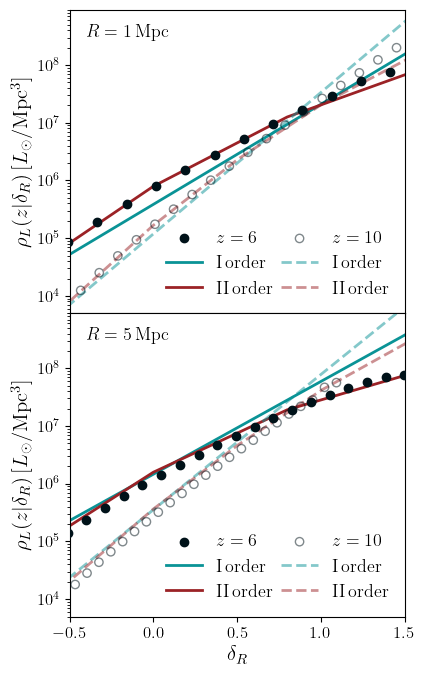

In [93]:
Nsigmad = 10.0 #how many sigmas we explore
Nds = 11 #how many deltas
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)

zArray_LIM, mArray_LIM, deltaNormArray_LIM = np.meshgrid(OIII_model.LIM_coeff.zintegral, OIII_model.HMFcl.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)

id = 0 

fig, axes = plt.subplots(2, 1, figsize=(4.5, 7), sharex=True, gridspec_kw={'hspace': 0})
ls = ['-','--']
color=[a.colors[0],'none']
alpha=[1,0.5]
for iz_val in [iz_val_0,iz_val_1]:
    # -----
    sigmaR_LIM_smallR = OIII_model.HMFcl.sigmaR_int(OIII_model_smallR.LP._R, OIII_model.LIM_coeff.zintegral[iz_val])
    sigmaR_LIM = OIII_model.HMFcl.sigmaR_int(OIII_model.LP._R, OIII_model.LIM_coeff.zintegral[iz_val])
    sigmaR_LIM_largeR = OIII_model.HMFcl.sigmaR_int(OIII_model_largeR.LP._R, OIII_model.LIM_coeff.zintegral[iz_val])

    deltaArray = deltatab_norm * sigmaR_LIM

    g1_smallR = OIII_model_smallR.LIM_coeff.gamma_LIM[iz_val]
    g1NL_smallR = OIII_model_smallR.LIM_coeff.gamma2_LIM[iz_val]
    g1s1_smallR = g1_smallR * sigmaR_LIM_smallR
    g1NLs1_smallR = g1NL_smallR * sigmaR_LIM_smallR**2

    # g1 = OIII_model.LIM_coeff.gamma_LIM[iz_val]
    # g1NL = OIII_model.LIM_coeff.gamma2_LIM[iz_val]
    # g1s1 = g1 * sigmaR_LIM
    # g1NLs1 = g1NL * sigmaR_LIM**2

    g1_largeR = OIII_model_largeR.LIM_coeff.gamma_LIM[iz_val]
    g1NL_largeR = OIII_model_largeR.LIM_coeff.gamma2_LIM[iz_val]
    g1s1_largeR = g1_largeR * sigmaR_LIM_largeR
    g1NLs1_largeR = g1NL_largeR * sigmaR_LIM_largeR**2

    # !!! the rhoL bar already includes the phi_LtoE correction
    rhoL_lin_smallR = OIII_lin_model_smallR.LIM_coeff.rhoL_bar[iz_val] * np.exp( g1_smallR*deltaArray - g1_smallR**2*sigmaR_LIM_smallR**2/2)

#    rhoL_lin = OIII_lin_model.LIM_coeff.rhoL_bar[iz_val] * np.exp( g1*deltaArray - g1**2*sigmaR_LIM**2/2)

    rhoL_lin_largeR = OIII_lin_model_largeR.LIM_coeff.rhoL_bar[iz_val] * np.exp( g1_largeR*deltaArray - g1_largeR**2*sigmaR_LIM_largeR**2/2)

    norm_smallR = np.exp(g1s1_smallR**2 / (2 - 4 * g1NLs1_smallR)) / np.sqrt(1-2*g1NLs1_smallR)
    #norm = np.exp(g1s1**2 / (2 - 4 * g1NLs1)) / np.sqrt(1-2*g1NLs1)
    norm_largeR = np.exp(g1s1_largeR**2 / (2 - 4 * g1NLs1_largeR)) / np.sqrt(1-2*g1NLs1_largeR)

    rhoL_quad_smallR = OIII_model_smallR.LIM_coeff.rhoL_bar[iz_val] *np.exp(g1_smallR *deltaArray + g1NL_smallR *deltaArray**2) / norm_smallR

    #rhoL_quad = OIII_model.LIM_coeff.rhoL_bar[iz_val] *np.exp(g1 *deltaArray + g1NL *deltaArray**2) / norm

    rhoL_quad_largeR = OIII_model_largeR.LIM_coeff.rhoL_bar[iz_val] *np.exp(g1_largeR *deltaArray + g1NL_largeR *deltaArray**2) / norm_largeR

    # use_bins = np.linspace(np.min(test_box[id].density_box),np.max(test_box[0].density_box),30)

    # bin_edges = np.zeros(len(use_bins) + 1)
    # bin_edges[1:-1] = (use_bins[:-1] + use_bins[1:]) / 2
    # bin_edges[0] = use_bins[0] - (bin_edges[1] - use_bins[0])
    # bin_edges[-1] = use_bins[-1] + (use_bins[-1] - bin_edges[-2])

    # bin_indices = np.digitize(test_box[id].density_box, bin_edges)
    # rhoL_binned =([test_box[id].rhoL_box[bin_indices == i] for i in range(1, len(bin_edges))])
    # rhoL_plot = np.zeros(len(use_bins))
    # for i in range(len(use_bins)):
    #     rhoL_plot[i] = np.mean(rhoL_binned[i])
    
    use_bins_smallR = np.linspace(np.min(test_box_smallR[id].density_box),np.max(test_box_smallR[id].density_box),30)

    bin_edges = np.zeros(len(use_bins_smallR) + 1)
    bin_edges[1:-1] = (use_bins_smallR[:-1] + use_bins_smallR[1:]) / 2
    bin_edges[0] = use_bins_smallR[0] - (bin_edges[1] - use_bins_smallR[0])
    bin_edges[-1] = use_bins_smallR[-1] + (use_bins_smallR[-1] - bin_edges[-2])

    bin_indices = np.digitize(test_box_smallR[id].density_box, bin_edges)
    rhoL_binned_smallR =([test_box_smallR[id].rhoL_box[bin_indices == i] for i in range(1, len(bin_edges))])
    rhoL_plot_smallR = np.zeros(len(use_bins_smallR))
    for i in range(len(use_bins_smallR)):
        rhoL_plot_smallR[i] = np.mean(rhoL_binned_smallR[i]) 


    use_bins_largeR = np.linspace(np.min(test_box_largeR[id].density_box),np.max(test_box_largeR[id].density_box),30)

    bin_edges = np.zeros(len(use_bins_largeR) + 1)
    bin_edges[1:-1] = (use_bins_largeR[:-1] + use_bins_largeR[1:]) / 2
    bin_edges[0] = use_bins_largeR[0] - (bin_edges[1] - use_bins_largeR[0])
    bin_edges[-1] = use_bins_largeR[-1] + (use_bins_largeR[-1] - bin_edges[-2])

    bin_indices = np.digitize(test_box_largeR[id].density_box, bin_edges)
    rhoL_binned_largeR =([test_box_largeR[id].rhoL_box[bin_indices == i] for i in range(1, len(bin_edges))])
    rhoL_plot_largeR = np.zeros(len(use_bins_largeR))
    for i in range(len(use_bins_largeR)):
        rhoL_plot_largeR[i] = np.mean(rhoL_binned_largeR[i]) 

    axes[0].scatter(use_bins_smallR,rhoL_plot_smallR,label=r'$z=%g$'%round(OIII_model.LIM_coeff.zintegral[iz_val],1),color=a.colors[0],facecolor=color[id],marker='o',zorder=8,alpha=alpha[id])
    axes[0].semilogy(deltaArray,rhoL_lin_smallR,label=r'$\rm I\,order$',color=a.colors[2],zorder=1,ls=ls[id],alpha=alpha[id])
    axes[0].semilogy(deltaArray,rhoL_quad_smallR,label=r'$\rm II\,order$',color=a.colors[-1],zorder=1,ls=ls[id],alpha=alpha[id])

    axes[1].scatter(use_bins_largeR,rhoL_plot_largeR,label=r'$z=%g$'%round(OIII_model.LIM_coeff.zintegral[iz_val],1),color=a.colors[0],facecolor=color[id],marker='o',zorder=8,alpha=alpha[id])
    axes[1].semilogy(deltaArray,rhoL_lin_largeR,label=r'$\rm I\,order$',color=a.colors[2],zorder=1,ls=ls[id],alpha=alpha[id])
    axes[1].semilogy(deltaArray,rhoL_quad_largeR,label=r'$\rm II\,order$',color=a.colors[-1],zorder=1,ls=ls[id],alpha=alpha[id])

    id += 1

axes[0].text(0.05, 0.95, r'$R=%g\,{\rm Mpc}$'%round(OIII_model_smallR.LP._R,1), transform=axes[0].transAxes,
             fontsize=13, verticalalignment='top')
axes[0].set_xlabel(r'$\delta_R$',fontsize=15)
axes[0].set_ylabel(r'${\rho}_L(z|\delta_{R})\,[L_\odot/{\rm Mpc^3}]$',fontsize=15)
axes[0].legend(loc=4,ncol=2,columnspacing=0.5,fontsize=13)
axes[0].set_xlim(-0.5,1.5)
axes[0].set_ylim(5e3,9e8)

axes[1].text(0.05, 0.95, r'$R=%g\,{\rm Mpc}$'%round(OIII_model_largeR.LP._R,1), transform=axes[1].transAxes,
             fontsize=13, verticalalignment='top')
axes[1].set_xlabel(r'$\delta_R$',fontsize=15)
axes[1].set_ylabel(r'${\rho}_L(z|\delta_{R})\,[L_\odot/{\rm Mpc^3}]$',fontsize=15)
axes[1].legend(loc=4,ncol=2,columnspacing=0.5,fontsize=13)
axes[1].set_xlim(-0.5,1.5)
axes[1].set_ylim(5e3,9e8)

plt.tight_layout()
plt.savefig('./plots_paper1/luminosity_density.png',dpi=300,bbox_inches='tight')

## 2) Compare coeval maps and power spectrum

In [11]:
boxes = CoevalBox_LIM_analytical(OIII_model.LIM_coeff,OIII_model.LIM_corr,OIII_model.LIM_pk,OIII_model.LP,use_z[iz],Resolution,Lbox,Nbox)

In [12]:
boxes_smallR = CoevalBox_LIM_analytical(OIII_model_smallR.LIM_coeff,OIII_model_smallR.LIM_corr,OIII_model_smallR.LIM_pk,OIII_model_smallR.LP,use_z[iz],Resolution,Lbox,Nbox)
boxes_largeR = CoevalBox_LIM_analytical(OIII_model_largeR.LIM_coeff,OIII_model_largeR.LIM_corr,OIII_model_largeR.LIM_pk,OIII_model_largeR.LP,use_z[iz],Resolution,Lbox,Nbox)

boxes_lin = CoevalBox_LIM_analytical(OIII_lin_model.LIM_coeff,OIII_lin_model.LIM_corr,OIII_lin_model.LIM_pk,OIII_lin_model.LP,use_z[iz],Resolution,Lbox,Nbox)
boxes_lin_smallR = CoevalBox_LIM_analytical(OIII_lin_model_smallR.LIM_coeff,OIII_lin_model_smallR.LIM_corr,OIII_lin_model_smallR.LIM_pk,OIII_lin_model_smallR.LP,use_z[iz],Resolution,Lbox,Nbox)
boxes_lin_largeR = CoevalBox_LIM_analytical(OIII_lin_model_largeR.LIM_coeff,OIII_lin_model_largeR.LIM_corr,OIII_lin_model_largeR.LIM_pk,OIII_lin_model_largeR.LP,use_z[iz],Resolution,Lbox,Nbox)



The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 10.0
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 10.0


In [13]:
_slice = 0 

### A) Noiseless, unsmooth VS smooth analytic

In [14]:
k_bins = np.logspace(np.log10(2*np.pi/Lbox),np.log10(2*np.pi/Lbox*Nbox),10)

pk_LIM, k_LIM = res = pb.get_power(
            deltax = boxes.Inu_box_noiseless,
            boxlength=Lbox,
            bins = k_bins, )


In [15]:

pk_LIM_smallR, kLIM_smallR = res = pb.get_power(
            deltax = boxes_smallR.Inu_box_noiseless,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_largeR, kLIM_largeR = res = pb.get_power(
            deltax = boxes_largeR.Inu_box_noiseless,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_smallR_smooth, kLIM_smallR_smooth = res = pb.get_power(
            deltax = boxes_smallR.Inu_box_noiseless_smooth,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_smooth, k_LIM = res = pb.get_power(
            deltax = boxes.Inu_box_noiseless_smooth,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_largeR_smooth, kLIM_largeR = res = pb.get_power(
            deltax = boxes_largeR.Inu_box_noiseless_smooth,
            boxlength=Lbox,
            bins = k_bins, )

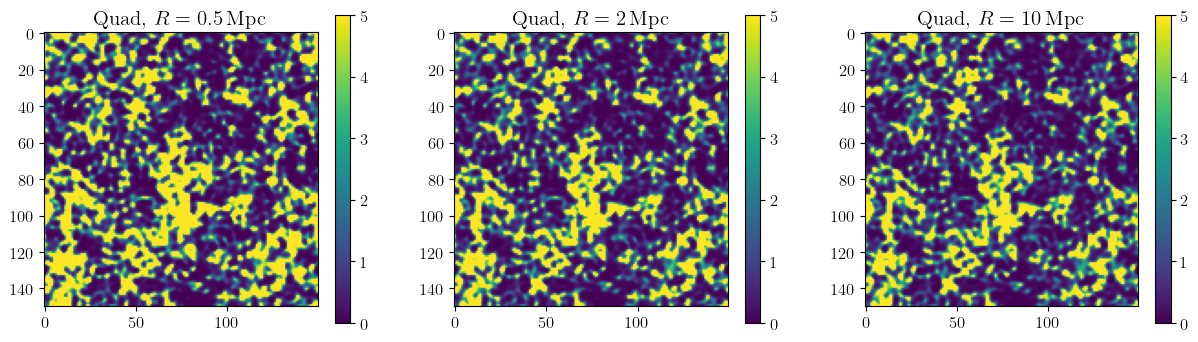

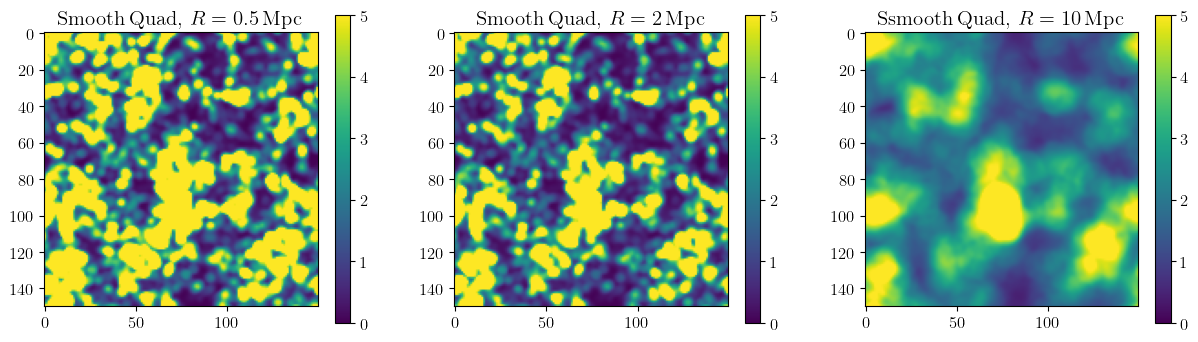

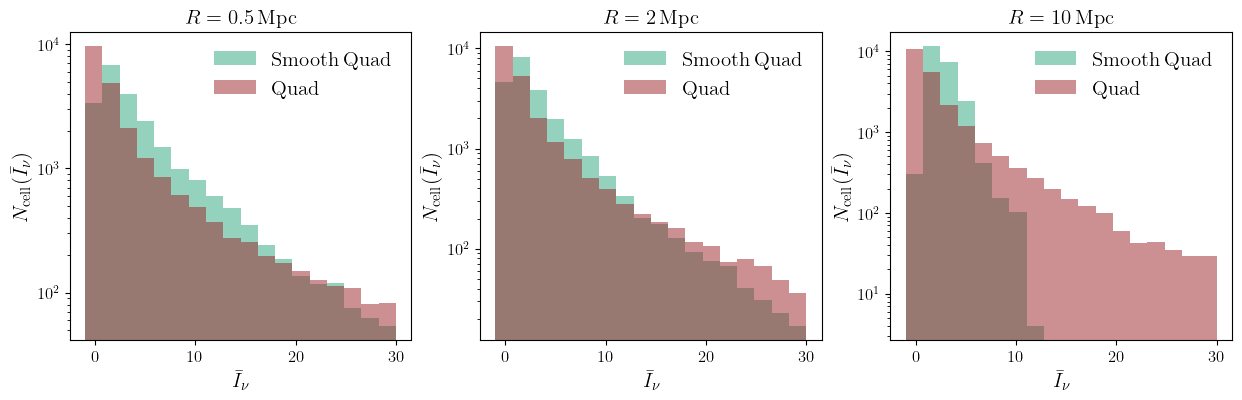

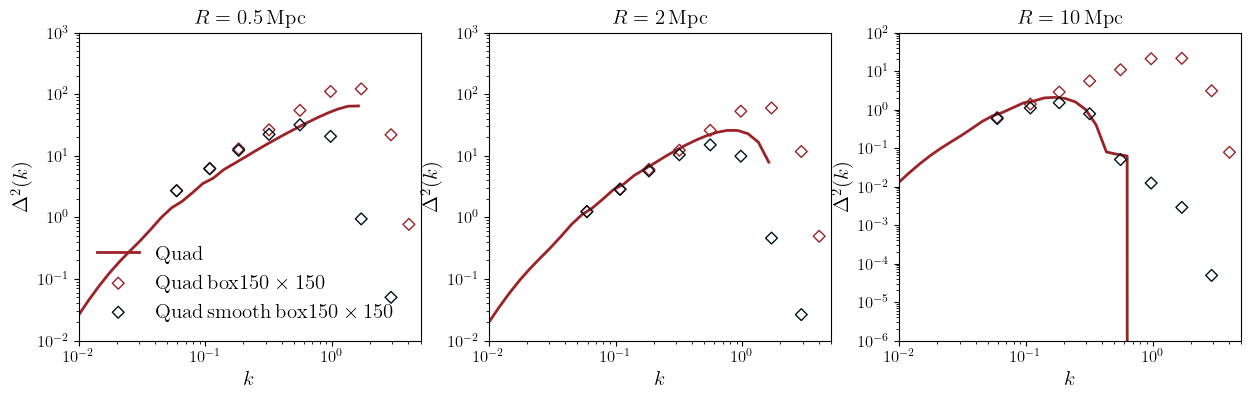

In [16]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(boxes_smallR.Inu_box_noiseless[_slice],vmin = 0,vmax=5)
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(boxes.Inu_box_noiseless[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)

plt.subplot(133)
plt.imshow(boxes_largeR.Inu_box_noiseless[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(boxes_smallR.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.title(r'${\rm Smooth\,Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(boxes.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Smooth\, Quad},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)

plt.subplot(133)
plt.imshow(boxes_largeR.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Ssmooth\,Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)


plt.figure(figsize=(15,4))

plt.subplot(131)
bin_hist = np.linspace(-1,30,19)
plt.hist(boxes_smallR.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Smooth\,Quad$',color=a.colors[3],)
plt.hist(boxes_smallR.Inu_box_noiseless[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad$',color=a.colors[-1],alpha=0.5,)
plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.yscale('log')

plt.subplot(132)
plt.hist(boxes.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Smooth\,Quad$',color=a.colors[3],)
plt.hist(boxes.Inu_box_noiseless[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad$',color=a.colors[-1],alpha=0.5,)
plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.yscale('log')

plt.subplot(133)
plt.hist(boxes_largeR.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Smooth\,Quad$',color=a.colors[3],)
plt.hist(boxes_largeR.Inu_box_noiseless[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad$',color=a.colors[-1],alpha=0.5,)

plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)
plt.yscale('log')

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.loglog(OIII_model_smallR.LIM_pk.klist_PS, OIII_model_smallR.LIM_pk.Deltasq_LIM[iz_val], color=a.colors[-1], label=r'$\rm Quad$')

plt.scatter(kLIM_smallR, pk_LIM_smallR * kLIM_smallR**3/2/np.pi**2, marker='D', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\, box 150\times 150$')
plt.scatter(kLIM_smallR, pk_LIM_smallR_smooth * kLIM_smallR**3/2/np.pi**2, marker='D', facecolor='none',zorder=10,color=a.colors[0],label=r'$\rm Quad\,smooth\, box 150\times 150$')

plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.ylim(1e-2,1e3)
plt.xlim(1e-2,5)


plt.subplot(132)
plt.loglog(OIII_model.LIM_pk.klist_PS, OIII_model.LIM_pk.Deltasq_LIM[iz_val], color=a.colors[-1], label=r'$\rm Quad$')

plt.scatter(kLIM_smallR_smooth, pk_LIM * kLIM_smallR_smooth**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[-1],zorder=10,label=r'$\rm Quad\,box 150\times 150$')
plt.scatter(kLIM_smallR_smooth, pk_LIM_smooth * kLIM_smallR_smooth**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[0],zorder=10,label=r'$\rm Quad\,smooth\,box 150\times 150$')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
#plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.ylim(1e-2,1e3)
plt.xlim(1e-2,5)

plt.subplot(133)
plt.loglog(OIII_model_largeR.LIM_pk.klist_PS, OIII_model_largeR.LIM_pk.Deltasq_LIM[iz_val], color=a.colors[-1], label=r'$\rm Quad$')
plt.scatter(kLIM_smallR_smooth, pk_LIM_largeR * kLIM_smallR_smooth**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[-1],zorder=10,label=r'$\rm Quad\,box 150\times 150$')
plt.scatter(kLIM_smallR_smooth, pk_LIM_largeR_smooth * kLIM_smallR_smooth**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[0],zorder=10,label=r'$\rm Quad\,smooth\,box 150\times 150$')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
#plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)
plt.ylim(1e-6,1e2)
plt.xlim(1e-2,5)

plt.show()

### B) Noiseless + smooth analytic linear VS quad VS per cell

In [17]:
pk_LIM_percell_smallR, kLIMsmallR = res = pb.get_power(
            deltax = test_box_smallR[iz].Inu_box_noiseless,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_percell, kLIM = res = pb.get_power(
            deltax = test_box[iz].Inu_box_noiseless,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_percell_largeR, kLIMlargeR = res = pb.get_power(
            deltax = test_box_largeR[iz].Inu_box_noiseless,
            boxlength=Lbox,
            bins = k_bins, )

In [18]:
pk_LIM_lin_smallR_smooth, kLIM_lin_smallR = res = pb.get_power(
            deltax = boxes_lin_smallR.Inu_box_noiseless_smooth,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_lin_smooth, k_lin_LIM = res = pb.get_power(
            deltax = boxes_lin.Inu_box_noiseless_smooth,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_lin_largeR_smooth, kLIM_lin_largeR = res = pb.get_power(
            deltax = boxes_lin_largeR.Inu_box_noiseless_smooth,
            boxlength=Lbox,
            bins = k_bins, )

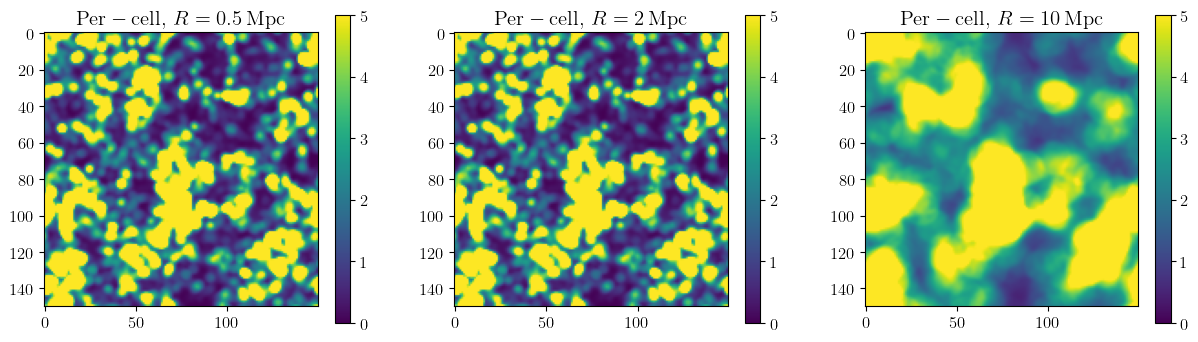

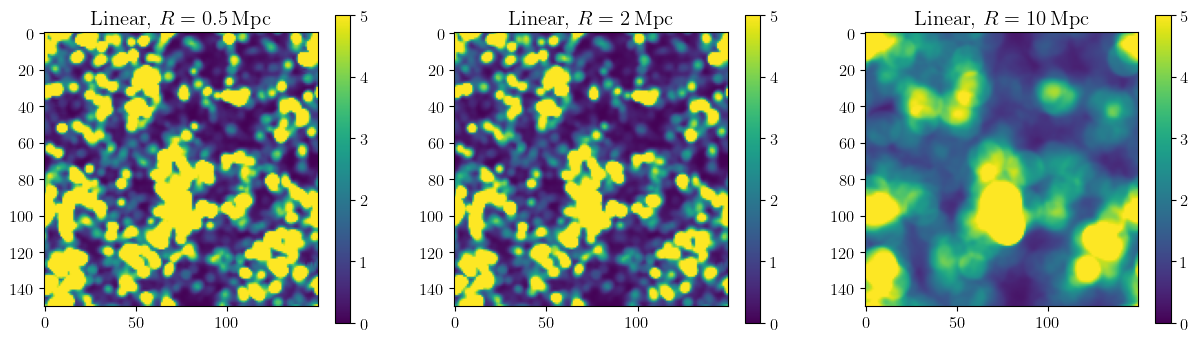

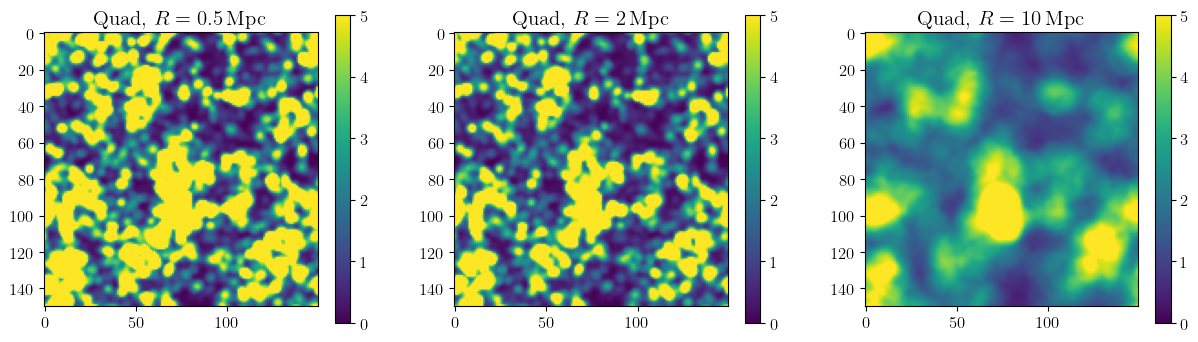

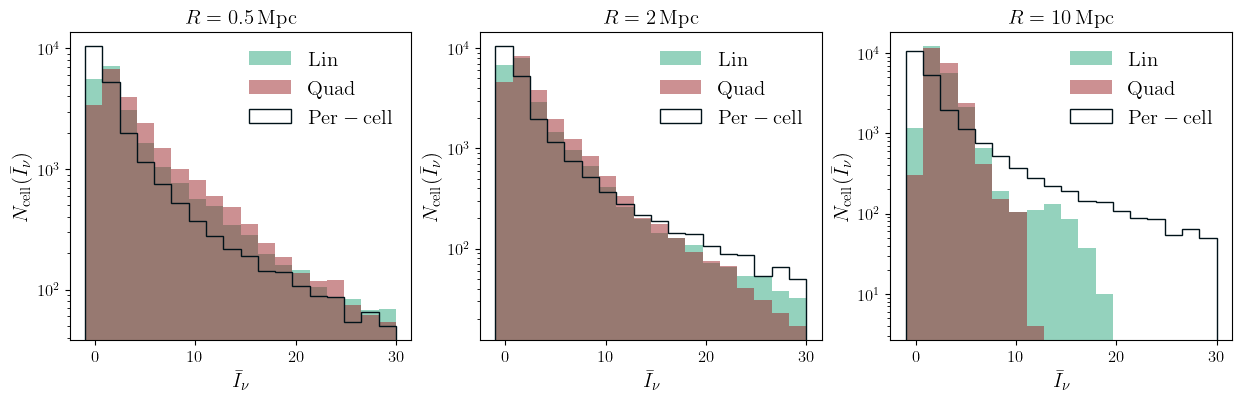

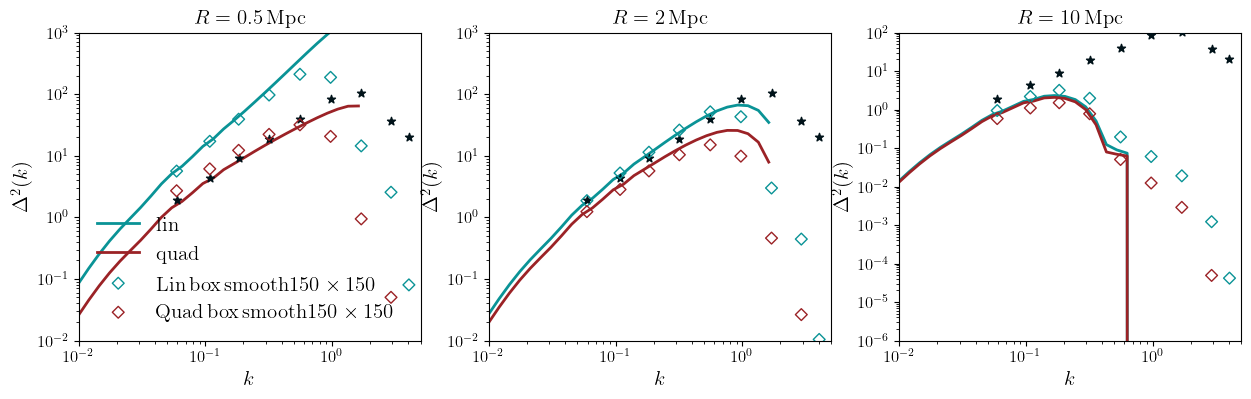

In [19]:

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(test_box_smallR[iz].Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.title(r'${\rm Per-cell},\,R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(test_box[iz].Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Per-cell},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)

plt.subplot(133)
plt.imshow(test_box_largeR[iz].Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Per-cell},\,R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(boxes_lin_smallR.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.title(r'${\rm Linear},\,R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(boxes_lin.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Linear},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)

plt.subplot(133)
plt.imshow(boxes_lin_largeR.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Linear},\,R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(boxes_smallR.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(boxes.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)

plt.subplot(133)
plt.imshow(boxes_largeR.Inu_box_noiseless_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)


plt.figure(figsize=(15,4))

plt.subplot(131)
bin_hist = np.linspace(-1,30,19)
plt.hist(boxes_lin_smallR.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Lin$',color=a.colors[3],)
plt.hist(boxes_smallR.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad$',color=a.colors[-1],alpha=0.5,)
plt.hist(test_box_smallR[iz].Inu_box_noiseless[_slice].flatten(),bins = bin_hist,label=r'$\rm Per-cell$',color=a.colors[0],histtype='step')
plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.yscale('log')

plt.subplot(132)
plt.hist(boxes_lin.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Lin$',color=a.colors[3],)
plt.hist(boxes.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad$',color=a.colors[-1],alpha=0.5,)
plt.hist(test_box[iz].Inu_box_noiseless[_slice].flatten(),bins = bin_hist,label=r'$\rm Per-cell$',color=a.colors[0],histtype='step')
plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.yscale('log')

plt.subplot(133)
plt.hist(boxes_lin_largeR.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Lin$',color=a.colors[3],)
plt.hist(boxes_largeR.Inu_box_noiseless_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad$',color=a.colors[-1],alpha=0.5,)
plt.hist(test_box_largeR[iz].Inu_box_noiseless[_slice].flatten(),bins = bin_hist,label=r'$\rm Per-cell$',color=a.colors[0],histtype='step')

plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)
plt.yscale('log')

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.loglog(OIII_lin_model_smallR.LIM_pk.klist_PS, OIII_lin_model_smallR.LIM_pk.Deltasq_LIM[iz_val],color=a.colors[2], label=r'$\rm lin$')
plt.loglog(OIII_model_smallR.LIM_pk.klist_PS, OIII_model_smallR.LIM_pk.Deltasq_LIM[iz_val], color=a.colors[-1], label=r'$\rm quad$')

plt.scatter(kLIMsmallR, pk_LIM_percell_smallR * kLIMsmallR**3/2/np.pi**2, marker='*',zorder=10,color=a.colors[0])
plt.scatter(kLIM_lin_smallR, pk_LIM_lin_smallR_smooth * kLIMsmallR**3/2/np.pi**2, marker='D', facecolor='none',zorder=10,color=a.colors[2],label=r'$\rm Lin\, box\,smooth 150\times 150$')
plt.scatter(kLIM_smallR, pk_LIM_smallR_smooth * kLIMsmallR**3/2/np.pi**2, marker='D', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\, box\,smooth 150\times 150$')

plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.ylim(1e-2,1e3)
plt.xlim(1e-2,5)


plt.subplot(132)
plt.loglog(OIII_lin_model.LIM_pk.klist_PS, OIII_lin_model.LIM_pk.Deltasq_LIM[iz_val],color=a.colors[2], label=r'$\rm lin$')
plt.loglog(OIII_model.LIM_pk.klist_PS, OIII_model.LIM_pk.Deltasq_LIM[iz_val], color=a.colors[-1], label=r'$\rm quad$')
plt.scatter(kLIM, pk_LIM_percell * kLIM**3/2/np.pi**2, marker='*',color=a.colors[0],zorder=10,label=r'$\rm box 150\times 150$')
plt.scatter(kLIM, pk_LIM_lin_smooth * kLIM**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[2],zorder=10,label=r'$\rm Lin\,box\,smooth 150\times 150$')
plt.scatter(kLIM, pk_LIM_smooth * kLIM**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[-1],zorder=10,label=r'$\rm Quad\,box\,smooth 150\times 150$')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
#plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.ylim(1e-2,1e3)
plt.xlim(1e-2,5)

plt.subplot(133)
plt.loglog(OIII_lin_model_largeR.LIM_pk.klist_PS, OIII_lin_model_largeR.LIM_pk.Deltasq_LIM[iz_val],color=a.colors[2], label=r'$\rm lin$')
plt.loglog(OIII_model_largeR.LIM_pk.klist_PS, OIII_model_largeR.LIM_pk.Deltasq_LIM[iz_val], color=a.colors[-1], label=r'$\rm quad$')
plt.scatter(kLIMlargeR, pk_LIM_percell_largeR * kLIMlargeR**3/2/np.pi**2, marker='*',color=a.colors[0],zorder=10,label=r'$\rm box 150\times 150$')
plt.scatter(kLIMlargeR, pk_LIM_lin_largeR_smooth * kLIMlargeR**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[2],zorder=10,label=r'$\rm Lin\,box\,smooth 150\times 150$')
plt.scatter(kLIMlargeR, pk_LIM_largeR_smooth * kLIMlargeR**3/2/np.pi**2, marker='D', facecolor='none',color=a.colors[-1],zorder=10,label=r'$\rm Quad\,box\,smooth 150\times 150$')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
#plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)
plt.ylim(1e-6,1e2)
plt.xlim(1e-2,5)

plt.show()

### C) Noiseless VS with Shot Noise

In [20]:
pk_LIM_smallR_WS_smooth, kLIM_small = pb.get_power(
            deltax = boxes_smallR.Inu_box_smooth,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_WS_smooth, k_LIM = pb.get_power(
            deltax = boxes.Inu_box_smooth,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_largeR_WS_smooth, kLIM_largeR = pb.get_power(
            deltax = boxes_largeR.Inu_box_smooth,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_smallR_WS, kLIM_small = pb.get_power(
            deltax = boxes_smallR.Inu_box,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_WS, k_LIM = pb.get_power(
            deltax = boxes.Inu_box,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM_largeR_WS, kLIM_largeR = pb.get_power(
            deltax = boxes_largeR.Inu_box,
            boxlength=Lbox,
            bins = k_bins, )

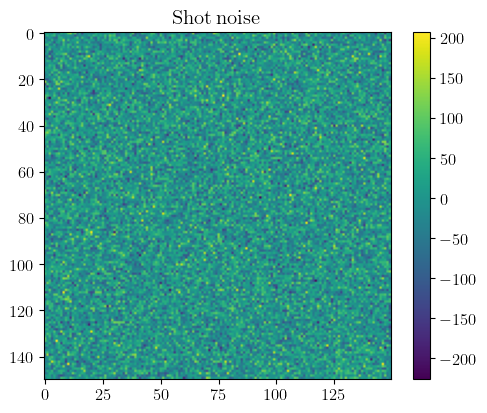

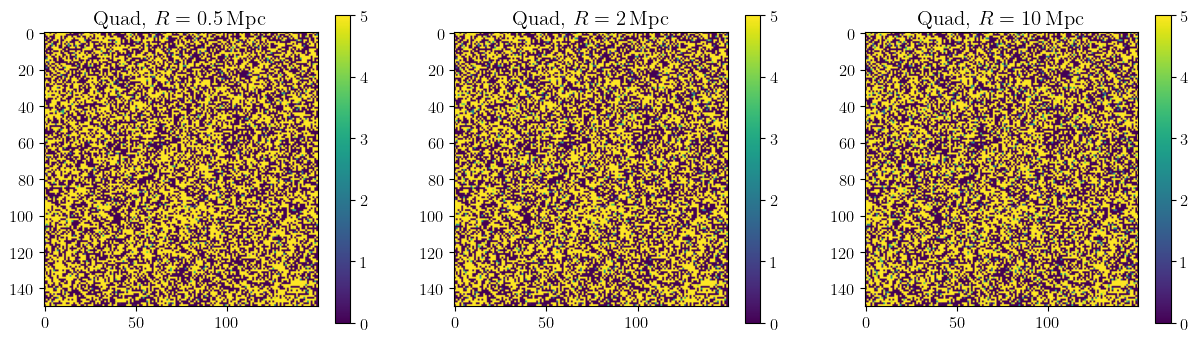

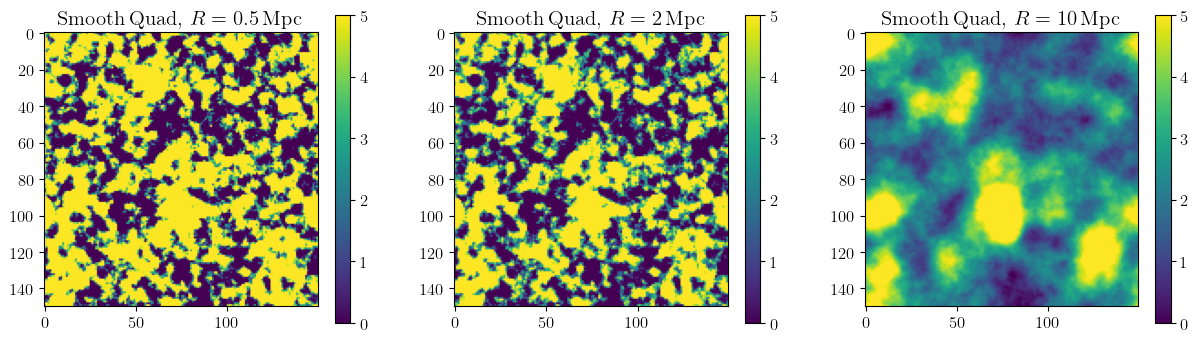

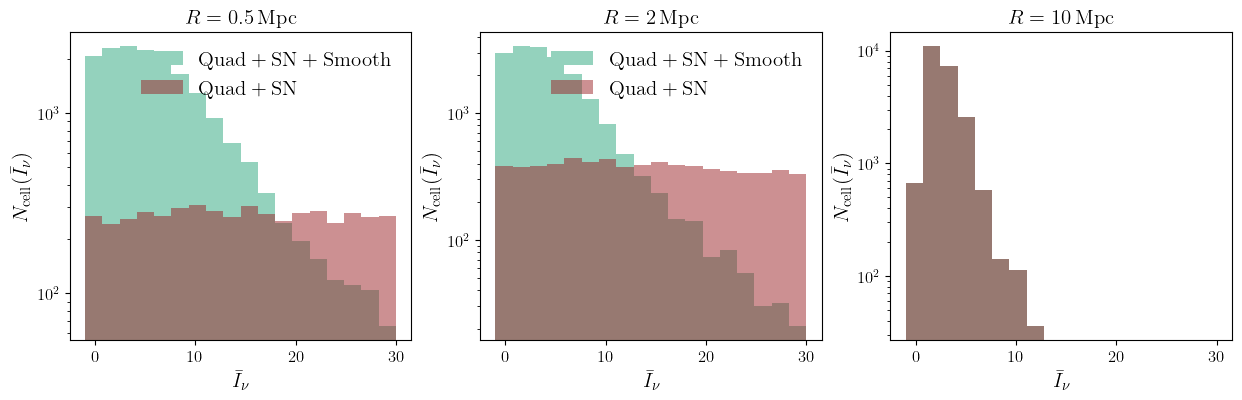

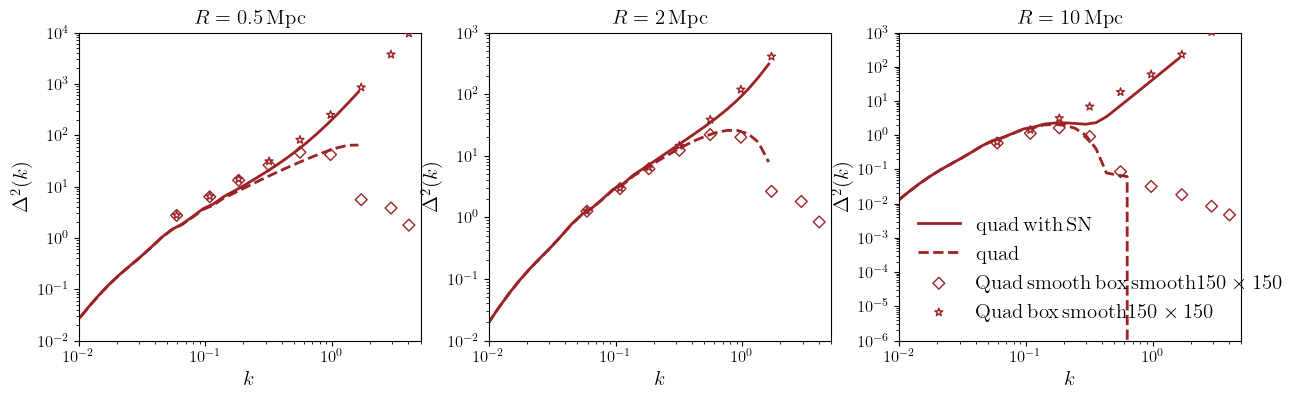

In [21]:
plt.imshow(boxes_smallR.shotnoise_box[_slice],)
plt.title(r'${\rm Shot\,noise}$')
plt.colorbar()


plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(boxes_smallR.Inu_box[_slice],vmin = 0,vmax=5)
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(boxes.Inu_box[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)

plt.subplot(133)
plt.imshow(boxes_largeR.Inu_box[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(boxes_smallR.Inu_box_smooth[_slice],vmin = 0,vmax=5)
plt.title(r'${\rm Smooth\, Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.colorbar()

plt.subplot(132)
plt.imshow(boxes.Inu_box_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Smooth\,Quad},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)

plt.subplot(133)
plt.imshow(boxes_largeR.Inu_box_smooth[_slice],vmin = 0,vmax=5)
plt.colorbar()
plt.title(r'${\rm Smooth\,Quad},\,R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)

plt.figure(figsize=(15,4))

plt.subplot(131)
bin_hist = np.linspace(-1,30,19)
plt.hist(boxes_smallR.Inu_box_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad+SN+Smooth$',color=a.colors[3],)
plt.hist(boxes_smallR.Inu_box[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad+SN$',color=a.colors[-1],alpha=0.5,)
plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.yscale('log')

plt.subplot(132)
plt.hist(boxes.Inu_box_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad+SN+Smooth$',color=a.colors[3],)
plt.hist(boxes.Inu_box[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad+SN$',color=a.colors[-1],alpha=0.5,)
plt.legend()
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.yscale('log')

plt.subplot(133)
plt.hist(boxes_largeR.Inu_box_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad+SN+Smooth$',color=a.colors[3],)
plt.hist(boxes_largeR.Inu_box_smooth[_slice].flatten(),bins = bin_hist,label=r'$\rm Quad+SN$',color=a.colors[-1],alpha=0.5,)
plt.xlabel(r'$\bar{I}_\nu$')
plt.ylabel(r'$N_{\rm cell}(\bar{I}_\nu)$')
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)
plt.yscale('log')


plt.figure(figsize=(15,4))
plt.subplot(131)
plt.loglog(OIII_model_smallR.LIM_pk.klist_PS, OIII_model_smallR.LIM_pk._Pk_LIM[iz_val]*OIII_model_smallR.LIM_pk._k3over2pi2 , color=a.colors[-1], label=r'$\rm quad$',ls='--')
plt.loglog(OIII_model_smallR.LIM_pk.klist_PS, OIII_model_smallR.LIM_pk._Pk_LIM_tot[iz_val]*OIII_model_smallR.LIM_pk._k3over2pi2 , color=a.colors[-1], label=r'$\rm quad\,with\,SN$')

plt.scatter(kLIM_smallR, pk_LIM_smallR_WS_smooth * kLIMsmallR**3/2/np.pi**2, marker='D', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\,smooth\, box\,smooth 150\times 150$')
plt.scatter(kLIM_smallR, pk_LIM_smallR_WS * kLIMsmallR**3/2/np.pi**2, marker='*', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\, box\,smooth 150\times 150$')

plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
#plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_smallR.LP._R)
plt.ylim(1e-2,1e4)
plt.xlim(1e-2,5)


plt.subplot(132)
plt.loglog(OIII_model.LIM_pk.klist_PS, OIII_model.LIM_pk._Pk_LIM_tot[iz_val]*OIII_model.LIM_pk._k3over2pi2 , color=a.colors[-1], label=r'$\rm quad\,with\,SN$')
plt.loglog(OIII_model.LIM_pk.klist_PS, OIII_model.LIM_pk._Pk_LIM[iz_val]*OIII_model.LIM_pk._k3over2pi2 , color=a.colors[-1], label=r'$\rm quad$',ls='--')

plt.scatter(kLIM_smallR, pk_LIM_WS_smooth * kLIMsmallR**3/2/np.pi**2, marker='D', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\,smooth\, box\,smooth 150\times 150$')
plt.scatter(kLIM_smallR, pk_LIM_WS * kLIMsmallR**3/2/np.pi**2, marker='*', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\, box\,smooth 150\times 150$')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
#plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.ylim(1e-2,1e3)
plt.xlim(1e-2,5)

plt.subplot(133)
plt.loglog(OIII_model_largeR.LIM_pk.klist_PS, OIII_model_largeR.LIM_pk._Pk_LIM_tot[iz_val]*OIII_model_largeR.LIM_pk._k3over2pi2 , color=a.colors[-1], label=r'$\rm quad\,with\,SN$')
plt.loglog(OIII_model_largeR.LIM_pk.klist_PS, OIII_model_largeR.LIM_pk._Pk_LIM[iz_val]*OIII_model_largeR.LIM_pk._k3over2pi2 , color=a.colors[-1], label=r'$\rm quad$',ls='--')

plt.scatter(kLIM_largeR, pk_LIM_largeR_WS_smooth * kLIMsmallR**3/2/np.pi**2, marker='D', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\,smooth\, box\,smooth 150\times 150$')
plt.scatter(kLIM_smallR, pk_LIM_largeR_WS * kLIMsmallR**3/2/np.pi**2, marker='*', facecolor='none',zorder=10,color=a.colors[-1],label=r'$\rm Quad\, box\,smooth 150\times 150$')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta^2(k)$')
plt.legend()
plt.title(r'$R=%g\,{\rm Mpc}$'%OIII_model_largeR.LP._R)
plt.ylim(1e-6,1e3)
plt.xlim(1e-2,5)

plt.show()

# CROSS CORRELATION WITH 21cm

In [22]:
box_only_T21 = a.CoevalMaps(OIII_model.zeus_coeff,OIII_model.zeus_pk,use_z[iz],Lbox=Lbox,Nbox=Nbox,KIND=1)

ClassyC = a.runclass(a.Cosmo_Parameters_Input(**a.CosmoParams_input_fid))
BMF = a.BMF(OIII_model.zeus_coeff, OIII_model.HMFcl,OIII_model.CP,OIII_model.AP)

box_xHI = a.maps.reionization_maps(OIII_model.CP, ClassyC, OIII_model.zeus_corr, OIII_model.zeus_coeff, BMF,OIII_model.LIM_coeff.zintegral, input_boxlength=Lbox,ncells=Nbox,seed=1605,PRINT_TIMER=False,ENFORCE_BMF_SCALE=False,COMPUTE_MASSWEIGHTED_IONFRAC=True,COMPUTE_DENSITY_AT_ALLZ=True)

 60%|██████    | 6/10 [00:01<00:00,  5.83it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:17<00:00,  5.57it/s]


In [23]:
LIMFAST = [[5.1094834232845034, 4.440892098500626e-16],
[5.464148033924442, 0.0007042253521127861],
[5.703161141094832, 0.0028169014084509225],
[6.007710100231305, 0.07605633802816913],
[6.385505011565153, 0.17605633802816922],
[7.25289128758674, 0.4084507042253521],
[7.715497301464921, 0.5063380281690142],
[8.093292212798769, 0.5788732394366196],
[8.602158828064766, 0.6535211267605633],
[9.041634541249039, 0.7084507042253521],
[9.94371626831149, 0.8035211267605631],
[11.262143407864304, 0.8915492957746476],
[12.133384734001545, 0.929577464788732],
[12.750192752505786, 0.9492957746478868],]
LIMFAST = np.asarray(LIMFAST).T

zT = [6.5,7.5,8.5,9.5]
T = [0.83,0.63,0.43,0.23]

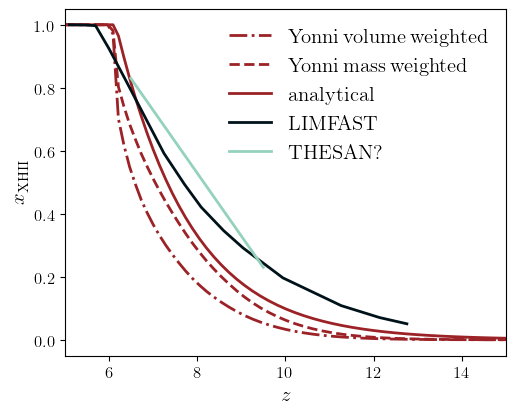

In [24]:
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI.ion_frac,label=r'$\rm Yonni\,volume\,weighted$',color=a.colors[-1],ls='-.')
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI.ion_frac_massweighted,label=r'$\rm Yonni\,mass\,weighted$',color=a.colors[-1],ls='--')
plt.plot(OIII_model.LIM_coeff.zintegral,1-OIII_model.zeus_coeff.xHI_avg,label=r'$\rm analytical$',color=a.colors[-1],ls='-')
plt.plot(LIMFAST[0], 1-LIMFAST[1], label=r'$\rm LIMFAST$',color=a.colors[0])
plt.plot(zT, T, label=r'$\rm THESAN?$',color=a.colors[3])
plt.xlim(5,15)
# plt.axhline(0.1)
# plt.axvline(10)
plt.xlabel(r'$z$')
plt.ylabel(r'$x_{\rm XHII}$')
plt.legend()

In [25]:
box_T21 = box_only_T21.T21map * (1-box_xHI.ion_field_allz[iz_val])

In [ ]:
my_box_T21 = CoevalBox_T21reionization(OIII_model.zeus_coeff,OIII_model.zeus_corr, OIII_model.zeus_pk,OIII_model.AP, OIII_model.CP, ClassyC,OIII_model.HMFcl, use_z[iz],Lbox,Nbox,)

 60%|██████    | 6/10 [00:00<00:00,  6.12it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:18<00:00,  5.30it/s]


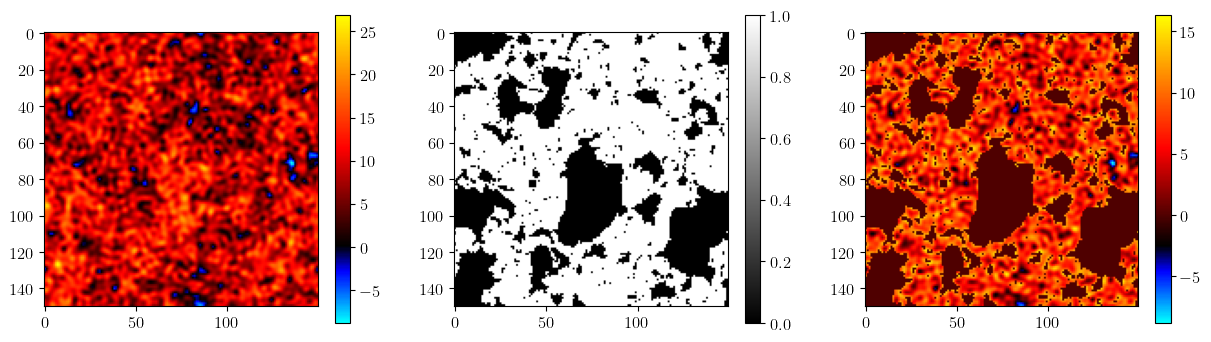

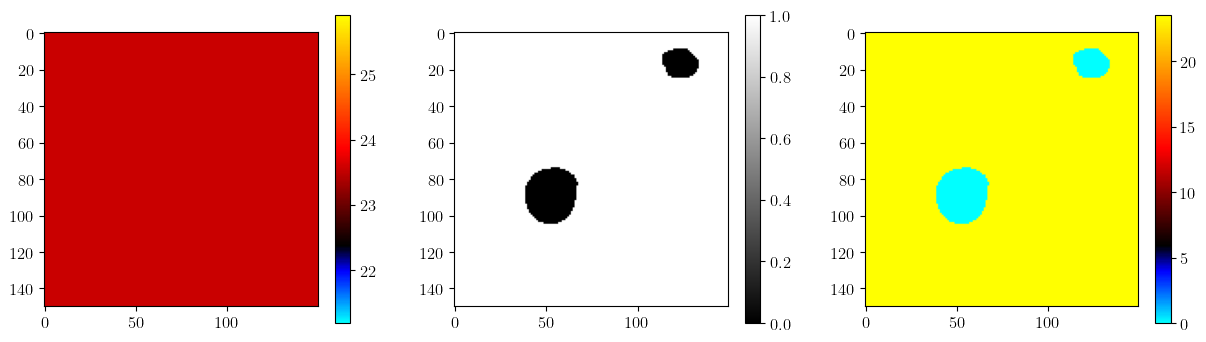

In [27]:
plt.figure(figsize=(15,4))
_slice = 0
min_value = -10
max_value = 30
mid_point = abs(min_value)/(abs(min_value)+abs(max_value))
colors_list = [(0, 'cyan'),
                (mid_point/1.5, 'blue'),
                (mid_point, "black"),
                ((1.+mid_point)/2.2, 'red'),
                (1, 'yellow')]
eor_colour = cc.LinearSegmentedColormap.from_list("eor_colour",colors_list)

plt.subplot(131)
plt.imshow(box_only_T21.T21map[_slice],cmap=eor_colour)
plt.colorbar()
plt.subplot(132)
plt.imshow(1-box_xHI.ion_field_allz[iz_val][_slice],cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(box_T21[_slice],cmap=eor_colour)
plt.colorbar()

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.imshow(my_box_T21.T21_map_only[_slice],cmap=eor_colour)
plt.colorbar()
plt.subplot(132)
plt.imshow(my_box_T21.xH_map[_slice],cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(my_box_T21.T21_map[_slice],cmap=eor_colour)
plt.colorbar()



In [28]:
pk_cross_noiseless, k_cross = pb.get_power(
    deltax = box_T21,
    boxlength= Lbox,
    deltax2 = boxes.Inu_box_noiseless,
    bins = k_bins
)

my_pk_cross_noiseless, k_cross = pb.get_power(
    deltax = my_box_T21.T21_map,
    boxlength= Lbox,
    deltax2 = boxes.Inu_box_noiseless,
    bins = k_bins
)

pk_cross, k_cross = pb.get_power(
    deltax = box_T21,
    boxlength= Lbox,
    deltax2 = boxes.Inu_box,
    bins = k_bins
)

my_pk_cross, k_cross = pb.get_power(
    deltax = my_box_T21.T21_map,
    boxlength= Lbox,
    deltax2 = boxes.Inu_box,
    bins = k_bins
)

pk_auto_OIII_noiseless = pb.get_power(
    deltax = boxes.Inu_box_noiseless,
    boxlength= Lbox,
    bins = k_bins
)[0]

pk_auto_OIII = pb.get_power(
    deltax = boxes.Inu_box,
    boxlength= Lbox,
    bins = k_bins
)[0]

pk_auto_21 = pb.get_power(
    deltax =box_T21,
    boxlength= Lbox,
    bins = k_bins
)[0]

my_pk_auto_21 = pb.get_power(
    deltax = my_box_T21.T21_map,
    boxlength= Lbox,
    bins = k_bins
)[0]


Text(0.5, 1.0, '$z=7$$,\\,x_{\\rm HII}=0.37$')

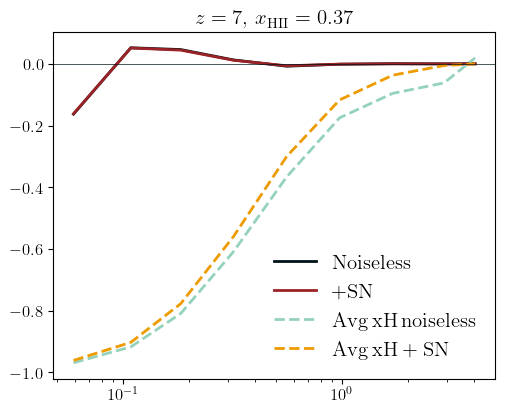

In [29]:
r_noiseless = pk_cross_noiseless/np.sqrt(pk_auto_OIII_noiseless*pk_auto_21)
r = pk_cross_noiseless/np.sqrt(pk_auto_OIII*pk_auto_21)

my_r_noiseless = my_pk_cross_noiseless/np.sqrt(pk_auto_OIII_noiseless*my_pk_auto_21)
my_r = my_pk_cross_noiseless/np.sqrt(pk_auto_OIII*my_pk_auto_21)

plt.semilogx(k_cross,my_r_noiseless,label=r'$\rm Noiseless$',color=a.colors[0])
plt.semilogx(k_cross,my_r,label=r'$\rm +SN$',color=a.colors[-1])
plt.semilogx(k_cross,r_noiseless,label=r'$\rm Avg\, xH\, noiseless$',color=a.colors[3],ls='--')
plt.semilogx(k_cross,r,label=r'$\rm Avg\,xH+SN$',color=a.colors[5],ls='--')

plt.axhline(0,linewidth=0.5)
plt.legend()
plt.title(r'$z=%g$'%round(OIII_model.LIM_coeff.zintegral[iz_val],1) + r'$,\,x_{\rm HII}=%g$'%round((box_xHI.ion_frac[iz_val]),2))

 60%|██████    | 6/10 [00:00<00:00,  7.13it/s]


SUCCESS: BMF converged in 6 iterations.


 60%|██████    | 6/10 [00:00<00:00,  6.23it/s]


SUCCESS: BMF converged in 6 iterations.


 60%|██████    | 6/10 [00:00<00:00,  6.11it/s]


SUCCESS: BMF converged in 6 iterations.


 60%|██████    | 6/10 [00:00<00:00,  6.31it/s]


SUCCESS: BMF converged in 6 iterations.


 60%|██████    | 6/10 [00:00<00:00,  6.30it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:18<00:00,  5.35it/s]
/tmp/ipykernel_64438/62921926.py:42: RuntimeWarning: invalid value encountered in divide
  r_v_noiseless = use_pk_cross_noiseless/np.sqrt(use_pk_auto_OIII_noiseless*use_pk_auto_21)
/tmp/ipykernel_64438/62921926.py:44: RuntimeWarning: invalid value encountered in divide
  r_v = use_pk_cross/np.sqrt(use_pk_auto_OIII*use_pk_auto_21)


Text(0, 0.5, '$r$')

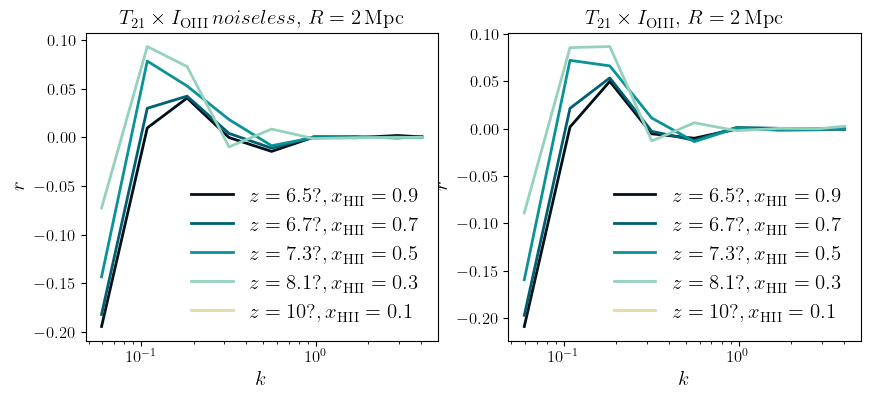

In [30]:
xHvals = [0.9,0.7,0.5,0.3,0.1]
zxHvals = [6.5,6.7,7.3,8.1,10]

plt.figure(figsize=(10,4))
for i in range(len(zxHvals)):
    use_box_T21 = CoevalBox_T21reionization(OIII_model.zeus_coeff,OIII_model.zeus_corr, OIII_model.zeus_pk,OIII_model.AP, OIII_model.CP, ClassyC,OIII_model.HMFcl,zxHvals[i],Resolution,Lbox,Nbox,)

    use_box_OIII = CoevalBox_LIM_analytical(OIII_model.LIM_coeff,OIII_model.LIM_corr,OIII_model.LIM_pk,OIII_model.LP,zxHvals[i],Resolution,Lbox,Nbox)

    use_pk_cross_noiseless, k_cross = pb.get_power(
    deltax = use_box_T21.T21_map,
    boxlength= Lbox,
    deltax2 = use_box_OIII.Inu_box_noiseless,
    bins = k_bins
    )

    use_pk_cross, k_cross = pb.get_power(
    deltax = use_box_T21.T21_map,
    boxlength= Lbox,
    deltax2 = use_box_OIII.Inu_box,
    bins = k_bins
    )

    use_pk_auto_OIII_noiseless = pb.get_power(
    deltax = use_box_OIII.Inu_box_noiseless,
    boxlength= Lbox,
    bins = k_bins
    )[0]

    use_pk_auto_OIII = pb.get_power(
    deltax = use_box_OIII.Inu_box,
    boxlength= Lbox,
    bins = k_bins
    )[0]

    use_pk_auto_21 = pb.get_power(
        deltax =use_box_T21.T21_map,
        boxlength= Lbox,
        bins = k_bins
    )[0]

    r_v_noiseless = use_pk_cross_noiseless/np.sqrt(use_pk_auto_OIII_noiseless*use_pk_auto_21)

    r_v = use_pk_cross/np.sqrt(use_pk_auto_OIII*use_pk_auto_21)

    plt.subplot(121)
    plt.semilogx(k_cross, r_v_noiseless, label=r'$z=%g?,\,$'%zxHvals[i]+r'$x_{\rm HII}=%g$'%xHvals[i])
    plt.subplot(122)
    plt.semilogx(k_cross, r_v, label=r'$z=%g?,\,$'%zxHvals[i]+r'$x_{\rm HII}=%g$'%xHvals[i])

plt.subplot(121)
plt.legend()
plt.title(r'$T_{21}\times I_{\rm OIII}\,noiseless,\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.xlabel(r'$k$')
plt.ylabel(r'$r$')

plt.subplot(122)
plt.legend()
plt.title(r'$T_{21}\times I_{\rm OIII},\,R=%g\,{\rm Mpc}$'%OIII_model.LP._R)
plt.xlabel(r'$k$')
plt.ylabel(r'$r$')

# COMPARE THE CODE WITH OTHER RESULTS

Text(0, 0.5, '$P(k)$')

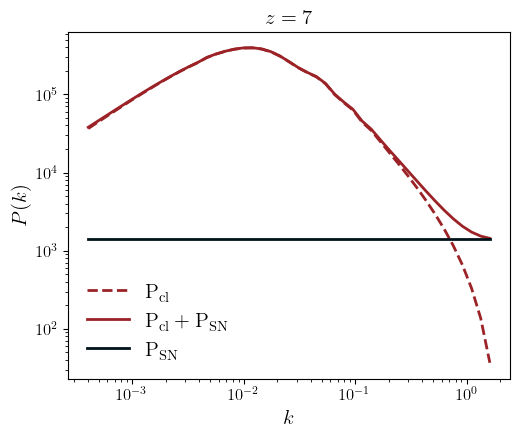

In [31]:
plt.loglog(OIII_model.LIM_pk.klist_PS ,OIII_model.LIM_pk._Pk_LIM[iz_val],label=r'$\rm P_{cl}$',color=a.colors[-1],ls='--')
plt.loglog(OIII_model.LIM_pk.klist_PS ,OIII_model.LIM_pk._Pk_LIM_tot[iz_val],label=r'$\rm P_{cl}+P_{SN}$',color=a.colors[-1],)
plt.loglog(OIII_model.LIM_pk.klist_PS ,OIII_model.LIM_pk.P_shot_noise[iz_val],label=r'$\rm P_{SN}$',color=a.colors[0],)
plt.title(r'$z=%g$'%round(OIII_model.LIM_coeff.zintegral[iz_val],1))
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:239: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:241: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)
/tmp/ipykernel_64438/153292321.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(M,np.log10(OIII[z_id,:]),label='GALLUMI+exp accretion',color=a.colors[-1])
/tmp/ipykernel_64438/153292321.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(M,np.log10(OIII_accr1[z_id,:]),label='GALLUMI+EPS accretion',color=a.colors[3])
/tmp/ipykernel_64438/153292321.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(M,np.log10(OIII_astro1[z_id,:]), label='21cmfast-like',color=a.colors[0])


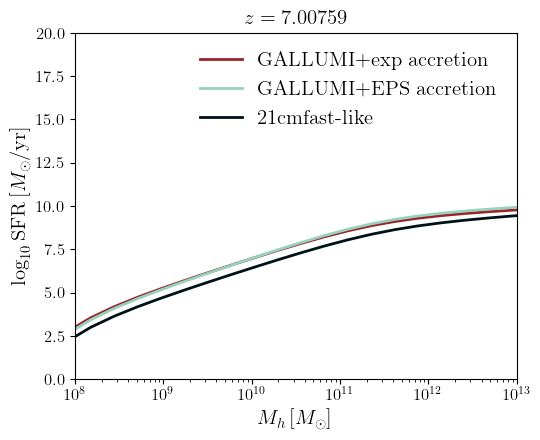

In [32]:
M = OIII_model.HMFcl.Mhtab

zArray_LIM, mArray_LIM, = np.meshgrid(OIII_model.LIM_coeff.zintegral, M, indexing = 'ij', sparse = True)

AP_accr1 = copy(OIII_model.AP)
AP_accr1.accretion_model = 1

AP_astro1 = copy(OIII_model.AP)
AP_astro1.astromodel = 1
AP_astro1.tstar = 0.5

z_id = 17

OIII = a.LineLuminosity(False, OIII_model.LP, OIII_model.AP, OIII_model.CP, OIII_model.HMFcl, mArray_LIM, zArray_LIM)
OIII_accr1 = a.LineLuminosity(False, OIII_model.LP, AP_accr1, OIII_model.CP, OIII_model.HMFcl, mArray_LIM, zArray_LIM,)
OIII_astro1 = a.LineLuminosity(False, OIII_model.LP, AP_astro1, OIII_model.CP, OIII_model.HMFcl, mArray_LIM, zArray_LIM, )

plt.semilogx(M,np.log10(OIII[z_id,:]),label='GALLUMI+exp accretion',color=a.colors[-1])
plt.semilogx(M,np.log10(OIII_accr1[z_id,:]),label='GALLUMI+EPS accretion',color=a.colors[3])
plt.semilogx(M,np.log10(OIII_astro1[z_id,:]), label='21cmfast-like',color=a.colors[0])
plt.ylim(0,20)
plt.xlim(1e8,1e13)
plt.xlabel(r'$M_h\,[M_\odot]$')
plt.ylabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
plt.title(r'$z=%g$'%OIII_model.LIM_coeff.zintegral[z_id])
plt.legend()
plt.show()

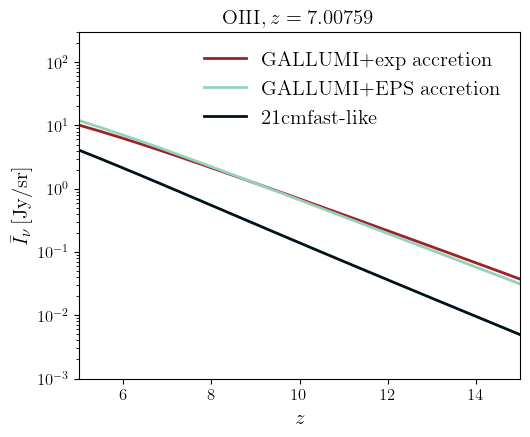

: 

In [ ]:
plt.semilogy(OIII_model.LIM_coeff.zintegral,OIII_model.LIM_coeff.Inu_bar,label='GALLUMI+exp accretion',color=a.colors[-1])

LIM_coeff_accr1 = a.get_LIM_coefficients(OIII_model.LP, AP_accr1, OIII_model.CP, OIII_model.HMFcl, OIII_model.UP, ZMIN)
plt.semilogy(OIII_model.LIM_coeff.zintegral,LIM_coeff_accr1.Inu_bar,ls='-',label='GALLUMI+EPS accretion',color=a.colors[3])

LIM_coeff_astro1 = a.get_LIM_coefficients(OIII_model.LP, AP_astro1, OIII_model.CP, OIII_model.HMFcl, OIII_model.UP, ZMIN)
plt.semilogy(OIII_model.LIM_coeff.zintegral,LIM_coeff_astro1.Inu_bar,ls='-',label='21cmfast-like',color=a.colors[0])


plt.title(r'${\rm OIII},\,$' + r'$z=%g$'%OIII_model.LIM_coeff.zintegral[z_id])
plt.xlabel(r'$z$')
plt.ylabel(r'$\bar{I}_\nu\,[{\rm Jy/sr}]$')
plt.xlim(5,15)
plt.ylim(1e-3,3e2)
plt.legend()
plt.show()

In [ ]:
zeus_coeff_accr1 = a.get_T21_coefficients(OIII_model.UP, OIII_model.CP, ClassyC, AP_accr1, OIII_model.HMFcl, ZMIN)
zeus_coeff_astro1 = a.get_T21_coefficients(OIII_model.UP, OIII_model.CP, ClassyC, AP_astro1, OIII_model.HMFcl, ZMIN)

BMF_astro1 = a.BMF(zeus_coeff_astro1, OIII_model.HMFcl,OIII_model.CP,AP_astro1)
BMF_accr1 = a.BMF(zeus_coeff_accr1, OIII_model.HMFcl,OIII_model.CP,AP_accr1)

box_xHI_21cmF = a.maps.reionization_maps(OIII_model.CP, ClassyC, OIII_model.zeus_corr, zeus_coeff_astro1, BMF_astro1,LIM_coeff_astro1.zintegral, input_boxlength=Lbox,ncells=Nbox,seed=1605,PRINT_TIMER=False,ENFORCE_BMF_SCALE=False,COMPUTE_MASSWEIGHTED_IONFRAC=True)
box_xHI_accr1 = a.maps.reionization_maps(OIII_model.CP, ClassyC, OIII_model.zeus_corr, zeus_coeff_accr1, BMF_accr1,LIM_coeff_accr1.zintegral, input_boxlength=Lbox,ncells=Nbox,seed=1605,PRINT_TIMER=False,ENFORCE_BMF_SCALE=False,COMPUTE_MASSWEIGHTED_IONFRAC=True)

 50%|█████     | 5/10 [00:00<00:00,  6.62it/s]


SUCCESS: BMF converged in 5 iterations.


 60%|██████    | 6/10 [00:00<00:00,  7.06it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:16<00:00,  6.02it/s]


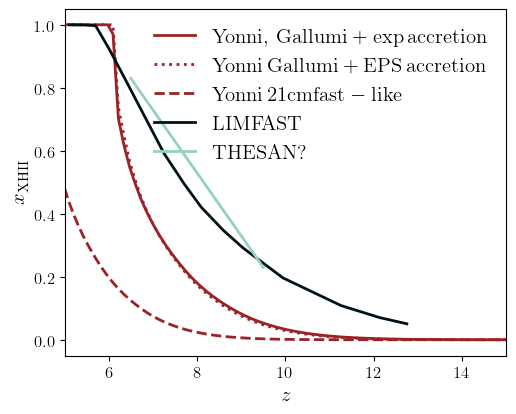

In [ ]:
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI.ion_frac,label=r'$\rm Yonni,\,Gallumi+exp\,accretion$',color=a.colors[-1],ls='-')
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI.ion_frac_massweighted,label=r'$\rm Yonni,\,Gallumi+exp\,accretion\,mass$',color=a.colors[-1],ls='--')
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI_accr1.ion_frac,label=r'$\rm Yonni\,Gallumi+EPS\,accretion$',color=a.colors[3],ls='-')
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI_accr1.ion_frac_massweighted,label=r'$\rm Yonni\,Gallumi+EPS\,accretion\,mass$',color=a.colors[3],ls='--')
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI_21cmF.ion_frac,label=r'$\rm Yonni\,21cmfast-like$',color=a.colors[0],ls='-')
plt.plot(OIII_model.LIM_coeff.zintegral,box_xHI_21cmF.ion_frac_massweighted,label=r'$\rm Yonni\,21cmfast-like\,mass$',color=a.colors[0],ls='--')

plt.plot(LIMFAST[0], 1-LIMFAST[1], label=r'$\rm LIMFAST$',color=a.colors[0],ls='.-')
plt.plot(zT, T, label=r'$\rm THESAN?$',color=a.colors[0],ls=':')
plt.xlim(5,15)
plt.xlabel(r'$z$')
plt.ylabel(r'$x_{\rm XHII}$')
plt.legend()